## Transformer Model for Hyperspectral Image Classification


### The MFT model with only HSI images used for classification. The other multimodal data is NOT used as external CLS token, rather the external CLS token is taken as random 

In [1]:
import sys
sys.path.append("./../")
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import math
from PIL import Image
import time
from scipy.io import loadmat as loadmat
from scipy import io
import random
import numpy as np
import os
import torch 
import torch.utils.data as dataf
import torch.nn as nn
from operator import truediv
import record
import pandas as pd
import seaborn as sns
from mft_model import MFT, Transformer
from dataset import Multimodal_Dataset_Train, Multimodal_Dataset_Test
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = False


In [2]:
def get_confusion_matrix(y_test,y_pred, plt_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
    df_cm.columns = ['Buildings','Woods', 'Roads', 'Apples', 'ground', 'Vineyard']
    df_cm = df_cm.rename({0:'Buildings',1:'Woods', 2:'Roads', 3:'Apples', 4:'ground', 5:'Vineyard'})
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.set(font_scale=0.9)#for label size
    sns.heatmap(df_cm, cmap="Blues",annot=True,annot_kws={"size": 16}, fmt='g')
    plt.savefig(''+str(plt_name)+'.eps', format='eps')

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

def reports (xtest,xtest2,ytest,name,model, HSIOnly, iternum):
    pred_y = np.empty((len(ytest)), dtype=np.float32)
    number = len(ytest) // testSizeNumber
    for i in range(number):
        temp = xtest[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
        temp = temp.cuda()
        temp1 = xtest2[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
        temp1 = temp1.cuda()
        if HSIOnly:
            temp2 = model(temp)
        else:
            temp2 = model(temp,temp1)
        temp3 = torch.max(temp2, 1)[1].squeeze()
        pred_y[i * testSizeNumber:(i + 1) * testSizeNumber] = temp3.cpu()
        del temp, temp2, temp3,temp1

    if (i + 1) * testSizeNumber < len(ytest):
        temp = xtest[(i + 1) * testSizeNumber:len(ytest), :, :]
        temp = temp.cuda()
        temp1 = xtest2[(i + 1) * testSizeNumber:len(ytest), :, :]
        temp1 = temp1.cuda()
        if HSIOnly:
            temp2 = model(temp)
        else:
            temp2 = model(temp,temp1)
        temp3 = torch.max(temp2, 1)[1].squeeze()
        pred_y[(i + 1) * testSizeNumber:len(ytest)] = temp3.cpu()
        del temp, temp2, temp3,temp1

    pred_y = torch.from_numpy(pred_y).long()
    
    oa = accuracy_score(ytest, pred_y)
    confusion = confusion_matrix(ytest, pred_y)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(ytest, pred_y)
    get_confusion_matrix(ytest, pred_y, 'test_'+str(iternum)+'')
    
    return confusion, oa*100, each_acc*100, aa*100, kappa*100


---------------------------------- Dataset details for  Trento  ---------------------------------------------


HSI Train data shape =  torch.Size([819, 63, 11, 11])
LIDAR Train data shape =  1
Train label shape =  torch.Size([819])
HSI Test data shape =  torch.Size([29395, 63, 11, 11])
LIDAR Test data shape =  1
Test label shape =  torch.Size([29395])
Number of Classes =  6


---------------------------------- Model Summary ---------------------------------------------


Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 8, 55, 11, 11]       --
|    └─Conv3d: 2-1                            [-1, 8, 55, 11, 11]       656
|    └─GroupNorm: 2-2                         [-1, 8, 55, 11, 11]       16
|    └─ReLU: 2-3                              [-1, 8, 55, 11, 11]       --
├─Sequential: 1-2                             [-1, 64, 11, 11]          --
|    └─HetConv: 2-4                           [-1, 64, 11, 11]     

Epoch:  98 | train loss: 0.0115 | test accuracy: 94.0092
Epoch:  99 | train loss: 0.0092 | test accuracy: 94.8699

The train time (in seconds) is: 1223.482893705368


Overall Accuracy =  95.45500935533255


----------Trento Training Finished -----------

The Confusion Matrix on test data


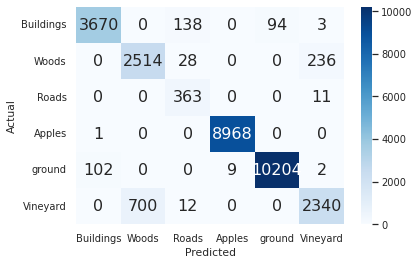

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
datasetNames = ["Trento"]
data2Name = 'LIDAR'

patchsize = 11
batchsize = 64
testSizeNumber = 500
EPOCH = 100
BandSize = 1
LR = 5e-4
FM = 16
HSIOnly = True
FileName = 'MFT_HSI'
ntokens = 4
token_type = 'channel' 
num_heads = 8
mlp_dim = 512
depth = 2
train_loss = []

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

for BandSize in [1]:
    for datasetName in datasetNames:
            print("---------------------------------- Dataset details for ",datasetName," ---------------------------------------------")
            print('\n')
            try:
                os.makedirs(datasetName)
            except FileExistsError:
                pass
            
            train_dataset = Multimodal_Dataset_Train(Filename=datasetName, MM_Data=data2Name)
            test_dataset = Multimodal_Dataset_Test(Filename=datasetName, MM_Data=data2Name)
            NC = train_dataset.hs_ims.shape[1]
            NCLidar = train_dataset.lid_ims.shape[1]
            Classes = len(torch.unique(train_dataset.lbs))

            train_loader = dataf.DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers= 4)
            print("HSI Train data shape = ", train_dataset.hs_ims.shape)
            print(data2Name + " Train data shape = ", train_dataset.lid_ims.shape[1])
            print("Train label shape = ", train_dataset.lbs.shape)

            print("HSI Test data shape = ", test_dataset.hs_ims.shape)
            print(data2Name + " Test data shape = ", test_dataset.lid_ims.shape[1])
            print("Test label shape = ", test_dataset.lbs.shape)

            print("Number of Classes = ", Classes)
            
            TestPatch1 = test_dataset.hs_ims
            TestPatch2 = test_dataset.lid_ims
            TestLabel1 = test_dataset.lbs
            
            KAPPA = []
            OA = []
            AA = []
            ELEMENT_ACC = np.zeros((3, Classes))

            set_seed(42)
            for iterNum in range(1):
                print('\n')
                print("---------------------------------- Model Summary ---------------------------------------------")
                print('\n')
                if HSIOnly:    
                    model = Transformer(FM=FM, NC=NC, Classes=Classes, ntokens=ntokens, num_heads=num_heads, mlp_dim=mlp_dim, depth=depth).cuda()
                    summary(model, [(NC, patchsize**2)])
                                        
                else:
                    model = MFT(FM=FM, NC=NC, NCLidar=NCLidar, Classes=Classes, ntokens=ntokens, token_type=token_type, num_heads=num_heads, mlp_dim=mlp_dim, depth=depth).cuda()
                    summary(model, [(NC, patchsize**2),(NCLidar,patchsize**2)])                    
                    
                optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=5e-3)
                loss_func = nn.CrossEntropyLoss()  # the target label is not one-hotted
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
                BestAcc = 0

                torch.cuda.synchronize()
                print('\n')
                print("---------------------------------- Training started for ",datasetName," ---------------------------------------------")
                print('\n')
                start = time.time()
                # train and test the designed model
                for epoch in range(EPOCH):
                    for step, (b_x1, b_x2, b_y) in enumerate(train_loader):

                        # move train data to GPU
                        b_x1 = b_x1.cuda()
                        b_y = b_y.cuda()
                        if HSIOnly:
                            out1 = model(b_x1)
                            loss = loss_func(out1, b_y)
                        else:
                            b_x2 = b_x2.cuda()
                            out= model(b_x1, b_x2)
                            loss = loss_func(out, b_y)

                        optimizer.zero_grad()  # clear gradients for this training step
                        loss.backward()  # backpropagation, compute gradients
                        optimizer.step()  # apply gradients

                        if step % 50 == 0:
                            model.eval()
                            pred_y = np.empty((len(TestLabel1)), dtype='float32')
                            number = len(TestLabel1) // testSizeNumber
                            for i in range(number):
                                temp = TestPatch1[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
                                temp = temp.cuda()
                                temp1 = TestPatch2[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
                                temp1 = temp1.cuda()
                                if HSIOnly:
                                    temp2 = model(temp)
                                    temp3 = torch.max(temp2, 1)[1].squeeze()
                                    pred_y[i * testSizeNumber:(i + 1) * testSizeNumber] = temp3.cpu()
                                    del temp, temp2, temp3
                                else:
                                    temp2 = model(temp, temp1)
                                    temp3 = torch.max(temp2, 1)[1].squeeze()
                                    pred_y[i * testSizeNumber:(i + 1) * testSizeNumber] = temp3.cpu()
                                    del temp, temp1, temp2, temp3

                            if (i + 1) * testSizeNumber < len(TestLabel1):
                                temp = TestPatch1[(i + 1) * testSizeNumber:len(TestLabel1), :, :]
                                temp = temp.cuda()
                                temp1 = TestPatch2[(i + 1) * testSizeNumber:len(TestLabel1), :, :]
                                temp1 = temp1.cuda()
                                if HSIOnly:
                                    temp2 = model(temp)
                                    temp3 = torch.max(temp2, 1)[1].squeeze()
                                    pred_y[(i + 1) * testSizeNumber:len(TestLabel1)] = temp3.cpu()
                                    del temp, temp2, temp3
                                else:
                                    temp2 = model(temp, temp1)
                                    temp3 = torch.max(temp2, 1)[1].squeeze()
                                    pred_y[(i + 1) * testSizeNumber:len(TestLabel1)] = temp3.cpu()
                                    del temp, temp1, temp2, temp3

                            pred_y = torch.from_numpy(pred_y).long()
                            accuracy = torch.sum(pred_y == TestLabel1).type(torch.FloatTensor) / TestLabel1.size(0)

                            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.4f' % (accuracy*100))
                            train_loss.append(loss.data.cpu().numpy())
                            # save the parameters in network
                            if accuracy > BestAcc:

                                BestAcc = accuracy
                                
                                torch.save(model.state_dict(), datasetName+'/net_params_'+FileName+'.pkl')
                                

                            model.train()
                    scheduler.step()
                torch.cuda.synchronize()
                end = time.time()
                print('\nThe train time (in seconds) is:', end - start)
                Train_time = end - start

                # load the saved parameters
                
                model.load_state_dict(torch.load(datasetName+'/net_params_'+FileName+'.pkl'))

                model.eval()
                
                confusion, oa, each_acc, aa, kappa = reports(TestPatch1,TestPatch2,TestLabel1,datasetName,model, HSIOnly, iterNum)
                KAPPA.append(kappa)
                OA.append(oa)
                AA.append(aa)
                ELEMENT_ACC[iterNum, :] = each_acc
                torch.save(model, datasetName+'/best_model_'+FileName+'_BandSize'+str(BandSize)+'_Iter'+str(iterNum)+'.pt')
                print('\n')
                print("Overall Accuracy = ", oa)
                print('\n')
            print("----------" + datasetName + " Training Finished -----------")
            print("\nThe Confusion Matrix on test data")
            record.record_output(OA, AA, KAPPA, ELEMENT_ACC,'./' + datasetName +'/'+FileName+'_BandSize'+str(BandSize)+'_Report_' + datasetName +'.txt')



In [4]:
train_loss = np.asarray(train_loss)
np.save('HSIOnly_train_loss.npy', train_loss)